# Finding the best no of Bounding Box Templates

### **Process** 
1. Download 180 images from the internet from hardhat,mask,boots and vest
2. Annotate via vgg Annotator
3. Download the COCO format json
4. Preprocess -Like normalising data, droping unnessary tables etc.
5. Find Optimal no of k using elbow method , apply mean IOU for all centroids.
6. Plot the graph- find the number of clusters,and its centroids



### Organisation of json file :
#### **keys** : 
       1. info - some info about the file like name, url, date created,description,version,contributer etc...
       2. images - this contains information of images
            * id - unique value
            * width	- width of the image
            * height - height of the image
            * file_name	- name of the file
            * license	- licence if any
            * date_captured - date when captured
       3   annotation - information about annotation that is done manually in vgg annotator
            * id  - unique value
            * image_id - which is the id of images. By this we can join images and annottaion fields
            * segmentation- Co-Ordinates of the bbox. For rectangle there will be 8 coordinates(4 x,y groups) - top-left,top-                 right, bottom-left, bottom-right.
            * area- area of bounding box
            * bbox - 4 points. top-left x point,top-left y point, width of bbox, height of bbox 
            * iscrowd - It defines whether there is a single image(iscrowd = 0) or group of objects(iscrowd = 1) 
       4   licence
       5   Categories - This will have the information of the field we annotated.like class, type -- whatever fields we chose
           Each category will have id , name, supercategory
           For example if we take a category about illumination. It will its own id , name , supercategory
       
**In this we only use images, annotation fields**
##   Load JSON and Form DataFrame 
         


In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Python program to read 
# json file 
  
  
import json 
import pandas as pd
  
# Opening JSON file 
f = open('/content/gdrive/My Drive/Colab Notebooks/eva5/Session12/S12-AssignmentB/image_coco.json') 
  
# returns JSON object as  

data = json.load(f) 
  

# list 
print(data.keys())
print('\n\n')
images = pd.DataFrame(data['images'], columns = data['images'][0].keys())
annotations = pd.DataFrame(data['annotations'], columns = data['annotations'][0].keys())


  
# Closing file 
f.close() 

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])





In [3]:
images.head()

,id,width,height,file_name,license,date_captured
0,1,533,800,800px_COLOURBOX2812880.jpg,0,
1,2,1250,729,2019-08-tsa-80.png,0,
2,3,853,1280,113917_1280.jpg,0,
3,4,1500,1120,5951370.jpg,0,
4,5,1500,1120,373031185.jpg,0,


In [4]:
annotations=annotations[['id','image_id','segmentation','area','bbox','iscrowd']]
annotations.head()

,id,image_id,segmentation,area,bbox,iscrowd
0,1,1,"[[107, 0, 432, 0, 432, 160, 107, 160]]",52000,"[107, 0, 325, 160]",0
1,2,2,"[[7, 242, 130, 242, 130, 313, 7, 313]]",8733,"[7, 242, 123, 71]",0
2,3,2,"[[264, 255, 369, 255, 369, 295, 264, 295]]",4200,"[264, 255, 105, 40]",0
3,4,2,"[[512, 247, 614, 247, 614, 309, 512, 309]]",6324,"[512, 247, 102, 62]",0
4,5,2,"[[888, 241, 980, 241, 980, 305, 888, 305]]",5888,"[888, 241, 92, 64]",0


## Preprocessing - Remove all unnecessary columns, spilt the bbox column

In [5]:
bbwidth = []
bbheight = []
bbx = []
bby = []
bbox = list(annotations['bbox'])
for i in bbox:
    bbx.append(i[0])
    bby.append(i[1])
    bbwidth.append(i[2])
    bbheight.append(i[3])
annotations['bbx'] = bbx
annotations['bby'] = bby
annotations['bbwidth'] = bbwidth
annotations['bbheight'] = bbheight
annotations = annotations.rename(columns={"image_id": "id"})
annotations = annotations.drop(["bbox","bbx","bby","id","segmentation","area","iscrowd"],axis =1)
annotations.head()


,bbwidth,bbheight
0,325,160
1,123,71
2,105,40
3,102,62
4,92,64


In [6]:
images = images.drop(["license","date_captured"],axis = 1)
images.head()

,id,width,height,file_name
0,1,533,800,800px_COLOURBOX2812880.jpg
1,2,1250,729,2019-08-tsa-80.png
2,3,853,1280,113917_1280.jpg
3,4,1500,1120,5951370.jpg
4,5,1500,1120,373031185.jpg


In [7]:
images.count()

id           183
width        183
height       183
file_name    183
dtype: int64

## Concatinate Both the files

In [8]:
finalfile = pd.concat([images,annotations],axis = 1)
finalfile = finalfile.drop(["id"],axis =1)
finalfile=finalfile.head(183)

In [ ]:
finalfile.tail()

,width,height,file_name,bbwidth,bbheight
178,1500.0,756.0,helmetcolours_1500.jpg,661,701
179,768.0,768.0,hi_visibilty_vest_childrens_kids_hv77_1.jpeg,826,707
180,635.0,300.0,High_Visibility_Safety_Vests.jpg,1047,834
181,816.0,610.0,high-vis-gear-work.png,738,454
182,450.0,531.0,hi-vis-vest1.jpg,202,298


## Normalise the image

In [9]:
finalfile['bbwidth'] = finalfile['bbwidth'].div(finalfile['width'])
finalfile['bbheight'] = finalfile['bbheight'].div(finalfile['height'])
finalfile['height'] = finalfile['height'].div(finalfile['height'])
finalfile['width'] = finalfile['width'].div(finalfile['width'])

finalfile.head()

,width,height,file_name,bbwidth,bbheight
0,1.0,1.0,800px_COLOURBOX2812880.jpg,0.609756,0.200000
1,1.0,1.0,2019-08-tsa-80.png,0.098400,0.097394
2,1.0,1.0,113917_1280.jpg,0.123095,0.031250
3,1.0,1.0,5951370.jpg,0.068000,0.055357
4,1.0,1.0,373031185.jpg,0.061333,0.057143


## Finally select only those columns which goes for Clustering (bound box height, bounding box width)

In [10]:
table_for_algo = finalfile.drop(["width","height","file_name"],axis = 1)
table_for_algo.head(50)

,bbwidth,bbheight
0,0.609756,0.200000
1,0.098400,0.097394
2,0.123095,0.031250
3,0.068000,0.055357
4,0.061333,0.057143
5,0.155889,0.056835
6,0.174365,0.100000
7,0.271667,0.340000
8,0.051190,0.054241
9,1.024510,1.021429


## Visualise the data

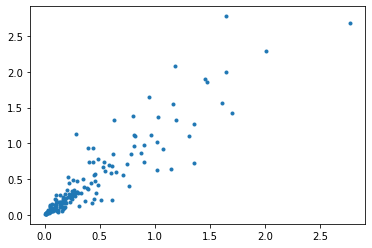

In [11]:
import matplotlib.pyplot as plt
plt.plot(table_for_algo['bbwidth'],table_for_algo['bbheight'],'.')


## Apply elbow method to find out k

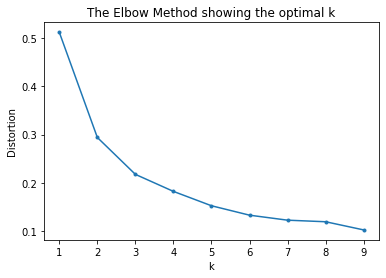

In [12]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt



# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(table_for_algo)
    kmeanModel.fit(table_for_algo)
    distortions.append(sum(np.min(cdist(table_for_algo, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) /table_for_algo.shape[0])

# Plot the elbow
plt.plot(K, distortions, '.-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## **Iou Method to find out K**

### IOU(Intersection over union) = intersected area of bbox and anchor box/ Union area of bbox and anchor box
#### bw = bounding box width, bh - bounding box height, aw - anchor box width, ah - anchor box height
#### IOU = min(bw,aw) * min(bh, ah)/bw*bh + aw*ah - min(bw,aw) * min(bh, ah)
#### mean IOU = sum(IOU)/len(IOU)

In [13]:
height = list(table_for_algo['bbheight'])
width = list(table_for_algo['bbwidth'])
ks = range(1,10)
meaniou = []
for k in ks:
    cl = KMeans(n_clusters=k)
    cl.fit(table_for_algo)
    cx = []
    cy = []
    mapcx  = {}
    mapcy = {}
    iou = []
    for i in range(50):
        
        l = cl.labels_[i]
        cx.append(cl.cluster_centers_[l][0])
        cy.append(cl.cluster_centers_[l][1])
        iou.append(min(width[i] ,cx[i])* min(height[i] , cy[i])/(height[i]*width[i]+ cx[i]*cy[i]- min(width[i] , cx[i])* min(height[i] ,cy[i])))
    meaniou.append(sum(iou)/50)  
        
        
 
        
        
        
        
        

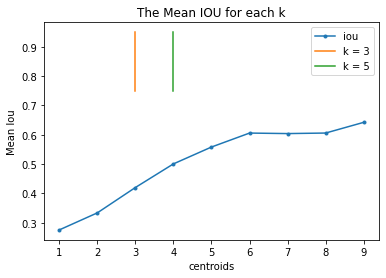

In [14]:

plt.plot(range(1,10),meaniou,'.-',label = "iou")
plt.plot([3,3],[0.75,0.95],label = "k = 3")
plt.plot([4,4],[0.75,0.95],label = "k = 5")
plt.xlabel('centroids')
plt.ylabel('Mean Iou')
plt.title('The Mean IOU for each k')
plt.legend()
plt.show()

In [ ]:
meaniou[3],meaniou[4],meaniou[5],meaniou[6]


(0.5006888256579974,
 0.5582062064867914,
 0.6087220338312498,
 0.6073496221020737)

##  We got K = 3 from elbow method, K = 5 from Mean IOU
### To visualise how both look we will plot a graph 

In [16]:
import numpy as np
array_points = np.array(table_for_algo)


## For k = 3

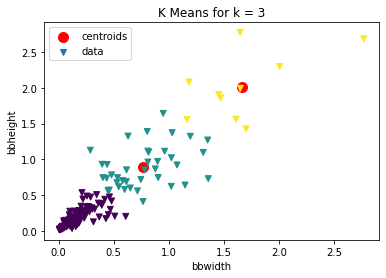

In [17]:
cl3 = KMeans(3)
cl3.fit(array_points)

plt.scatter(cl3.cluster_centers_[:,0] ,cl3.cluster_centers_[:,1], color='red',s = 100,marker = 'o', label='centroids')
plt.scatter(list(table_for_algo['bbwidth']), list(table_for_algo['bbheight']), marker="v",c=list(cl3.labels_.astype(float)), label = "data")
plt.legend()
plt.xlabel('bbwidth')
plt.ylabel('bbheight')
plt.title('K Means for k = 3')
plt.legend()
plt.show()

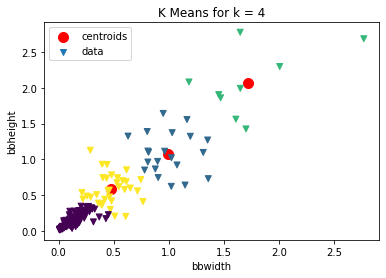

In [18]:
cl3 = KMeans(4)
cl3.fit(array_points)

plt.scatter(cl3.cluster_centers_[:,0] ,cl3.cluster_centers_[:,1], color='red',s = 100,marker = 'o', label='centroids')
plt.scatter(list(table_for_algo['bbwidth']), list(table_for_algo['bbheight']),marker="v", c=list(cl3.labels_.astype(float)), label = "data")
plt.legend(scatterpoints=1)
plt.xlabel('bbwidth')
plt.ylabel('bbheight')
plt.title('K Means for k = 4')
plt.legend()
plt.show()

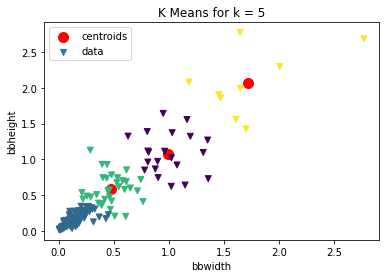

In [20]:
l3 = KMeans(5)
cl3.fit(array_points)

plt.scatter(cl3.cluster_centers_[:,0] ,cl3.cluster_centers_[:,1], color='red',s = 100,marker = 'o', label='centroids')
plt.scatter(list(table_for_algo['bbwidth']), list(table_for_algo['bbheight']),marker="v", c=list(cl3.labels_.astype(float)), label = "data")
plt.legend(scatterpoints=1)
plt.xlabel('bbwidth')
plt.ylabel('bbheight')
plt.title('K Means for k = 5')
plt.legend()
plt.show()

### From the visualisation we can see that for k = 3 and k =5. There isn't much difference and mean iou difference is 0.05. 3 May work fine.  Can play around with 3 and 5.
